In [1]:
import os as os
import numpy as np
import pandas as pd
from sklearn import mixture as mix
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import tweepy
import datetime as dt
from datetime import date, timedelta
import matplotlib.pyplot as plt
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
import glob
import time

# NLP Libraries
from textblob import TextBlob
from wordcloud import WordCloud
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Spacy
import spacy

#vis
import pyLDAvis
import pyLDAvis.gensim_models

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
dataframe=pd.read_csv('Dataset_final_noElectricity.csv')
data = pd.DataFrame(dataframe)
data.drop(['CO1_Ret', 'RotterdamCoal_Ret','GSCI_Ret','TZT1_Ret','STOXX600_Ret'], axis=1,inplace=True)
data['EUA_Price_L1'] = data['EUA_Carbon']
columns_df = data.columns[1:]
data

,Date,EUA_Carbon,EUA_Ret,CO1_BrentCrude,Rotterdam_Coal,GSCI_NonEnergyIndex,TZT1_NatGas,STOXX600,EUA_Price_L1
0,2014-01-02,97.58,-0.024200,113.72,80.750000,31.36,54.582,325.82,97.58
1,2014-01-03,97.17,-0.004202,112.83,79.500000,31.23,54.493,327.64,97.17
2,2014-01-06,95.35,-0.018730,112.67,79.750000,31.25,54.652,326.98,95.35
3,2014-01-07,96.16,0.008495,113.29,79.600000,31.26,54.429,329.40,96.16
4,2014-01-08,93.94,-0.023087,113.09,81.900000,31.00,54.710,329.75,93.94
...,...,...,...,...,...,...,...,...,...
1963,2021-11-23,1295.52,-0.010396,81.18,146.888889,17.73,91.277,479.25,1295.52
1964,2021-11-24,1365.24,0.053816,81.12,149.444444,17.66,94.334,479.69,1365.24
1965,2021-11-26,1363.19,-0.022326,71.59,146.000000,16.51,88.122,464.05,1363.19
1966,2021-11-29,1389.66,0.019418,73.22,128.000000,16.47,93.445,467.24,1389.66


In [3]:
columns_df = data.columns[1:-1]

In [4]:
columns_df

Index(['EUA_Carbon', 'EUA_Ret', 'CO1_BrentCrude', 'Rotterdam_Coal',
       'GSCI_NonEnergyIndex', 'TZT1_NatGas', 'STOXX600'],
      dtype='object')

In [5]:
#mask = ~(data.columns.isin(['EUA_Carbon','Date','CO1_BrentCrude','Rotterdam_Coal','Electricity','GSCI_NonEnergyIndex',
#                          'TZT1_NatGas','STOXX600','EUA_Ret']))

mask = ~(data.columns.isin(['Date','EUA_Carbon']))

cols_to_shift = data.columns[mask]

data_shifted = data.copy()
data_shifted[cols_to_shift] = data.loc[:,mask].shift(1)

In [6]:
data_shifted['EUA_Ret_L1'] = data_shifted['EUA_Ret']
data_shifted['EUA_Ret'] = data['EUA_Ret']

In [7]:
data_shifted

,Date,EUA_Carbon,EUA_Ret,CO1_BrentCrude,Rotterdam_Coal,GSCI_NonEnergyIndex,TZT1_NatGas,STOXX600,EUA_Price_L1,EUA_Ret_L1
0,2014-01-02,97.58,-0.024200,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-01-03,97.17,-0.004202,113.72,80.750000,31.36,54.582,325.82,97.58,-0.024200
2,2014-01-06,95.35,-0.018730,112.83,79.500000,31.23,54.493,327.64,97.17,-0.004202
3,2014-01-07,96.16,0.008495,112.67,79.750000,31.25,54.652,326.98,95.35,-0.018730
4,2014-01-08,93.94,-0.023087,113.29,79.600000,31.26,54.429,329.40,96.16,0.008495
...,...,...,...,...,...,...,...,...,...,...
1963,2021-11-23,1295.52,-0.010396,78.57,144.333333,17.35,84.367,485.46,1309.13,0.008186
1964,2021-11-24,1365.24,0.053816,81.18,146.888889,17.73,91.277,479.25,1295.52,-0.010396
1965,2021-11-26,1363.19,-0.022326,81.12,149.444444,17.66,94.334,479.69,1365.24,0.053816
1966,2021-11-29,1389.66,0.019418,71.59,146.000000,16.51,88.122,464.05,1363.19,-0.022326


In [8]:
data_shifted.dropna(inplace = True)
data_shifted.reset_index(drop=True, inplace=True)
data_shifted['Signal']=0
data_shifted.loc[data_shifted['EUA_Ret']>=0,'Signal']=1
data_shifted.loc[data_shifted['EUA_Ret']<0,'Signal']=-1

In [9]:
data_shifted

,Date,EUA_Carbon,EUA_Ret,CO1_BrentCrude,Rotterdam_Coal,GSCI_NonEnergyIndex,TZT1_NatGas,STOXX600,EUA_Price_L1,EUA_Ret_L1,Signal
0,2014-01-03,97.17,-0.004202,113.72,80.750000,31.36,54.582,325.82,97.58,-0.024200,-1
1,2014-01-06,95.35,-0.018730,112.83,79.500000,31.23,54.493,327.64,97.17,-0.004202,-1
2,2014-01-07,96.16,0.008495,112.67,79.750000,31.25,54.652,326.98,95.35,-0.018730,1
3,2014-01-08,93.94,-0.023087,113.29,79.600000,31.26,54.429,329.40,96.16,0.008495,-1
4,2014-01-09,92.53,-0.015010,113.09,81.900000,31.00,54.710,329.75,93.94,-0.023087,-1
...,...,...,...,...,...,...,...,...,...,...,...
1962,2021-11-23,1295.52,-0.010396,78.57,144.333333,17.35,84.367,485.46,1309.13,0.008186,-1
1963,2021-11-24,1365.24,0.053816,81.18,146.888889,17.73,91.277,479.25,1295.52,-0.010396,1
1964,2021-11-26,1363.19,-0.022326,81.12,149.444444,17.66,94.334,479.69,1365.24,0.053816,-1
1965,2021-11-29,1389.66,0.019418,71.59,146.000000,16.51,88.122,464.05,1363.19,-0.022326,1


# Benchmark testing

In [10]:
data_shifted['Signal_L1']=0
data_shifted.loc[data_shifted['EUA_Ret_L1']>=0,'Signal_L1']=1
data_shifted.loc[data_shifted['EUA_Ret_L1']<0,'Signal_L1']=-1

In [11]:
data_shifted

,Date,EUA_Carbon,EUA_Ret,CO1_BrentCrude,Rotterdam_Coal,GSCI_NonEnergyIndex,TZT1_NatGas,STOXX600,EUA_Price_L1,EUA_Ret_L1,Signal,Signal_L1
0,2014-01-03,97.17,-0.004202,113.72,80.750000,31.36,54.582,325.82,97.58,-0.024200,-1,-1
1,2014-01-06,95.35,-0.018730,112.83,79.500000,31.23,54.493,327.64,97.17,-0.004202,-1,-1
2,2014-01-07,96.16,0.008495,112.67,79.750000,31.25,54.652,326.98,95.35,-0.018730,1,-1
3,2014-01-08,93.94,-0.023087,113.29,79.600000,31.26,54.429,329.40,96.16,0.008495,-1,1
4,2014-01-09,92.53,-0.015010,113.09,81.900000,31.00,54.710,329.75,93.94,-0.023087,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
1962,2021-11-23,1295.52,-0.010396,78.57,144.333333,17.35,84.367,485.46,1309.13,0.008186,-1,1
1963,2021-11-24,1365.24,0.053816,81.18,146.888889,17.73,91.277,479.25,1295.52,-0.010396,1,-1
1964,2021-11-26,1363.19,-0.022326,81.12,149.444444,17.66,94.334,479.69,1365.24,0.053816,-1,1
1965,2021-11-29,1389.66,0.019418,71.59,146.000000,16.51,88.122,464.05,1363.19,-0.022326,1,-1


In [14]:
len(data_shifted[data_shifted["Signal"]==data_shifted["Signal_L1"]])/len(data_shifted)

0.47381799694966953

In [15]:
len(data_shifted[data_shifted["Signal"]==1])/len(data_shifted)

0.5373665480427047

# Sentiment Analysis

In [16]:
# import dataset
tweets_df = pd.read_csv("tweets/combined_tweets_df.csv")

In [17]:
tweets_df = tweets_df[tweets_df[ "Compound"]!=0].reset_index(drop=True)

In [18]:
tweets_groupby_df = tweets_df.copy()
tweets_groupby_df = tweets_groupby_df.groupby('Date').agg({'Polarity':'mean','Subjectivity':'mean','Compound':'mean','Lemmatized Tokens': lambda x: ' '.join(x)})

In [19]:
reddit_df = pd.read_csv("combined_reddit_df.csv")

In [21]:
reddit_df = reddit_df[reddit_df["Compound"]!=0].reset_index(drop=True)
reddit_groupby_df = reddit_df.copy()
reddit_groupby_df = reddit_groupby_df.groupby('Date').agg({'Polarity':'mean','Subjectivity':'mean','Compound':'mean','Lemmatized Tokens': lambda x: ' '.join(x)})

In [22]:
mask = ~(tweets_groupby_df.columns.isin(['Date','Lemmatized Tokens']))

cols_to_shift = tweets_groupby_df.columns[mask]
cols_L1 = ['Polarity_L1','Subjectivity_L1','Compound_L1']
cols_L2 = ['Polarity_L2','Subjectivity_L2','Compound_L2']
cols_L3 = ['Polarity_L3','Subjectivity_L3','Compound_L3']

tweets_groupby_df_shifted = tweets_groupby_df.copy()
tweets_groupby_df_shifted[cols_L1] = tweets_groupby_df.loc[:,mask].shift(1)
tweets_groupby_df_shifted[cols_L2] = tweets_groupby_df.loc[:,mask].shift(2)
tweets_groupby_df_shifted[cols_L3] = tweets_groupby_df.loc[:,mask].shift(3)

In [23]:
mask = ~(reddit_groupby_df.columns.isin(['Date','Lemmatized Tokens']))

cols_L1 = ['Polarity_L1_R','Subjectivity_L1_R','Compound_L1_R']
cols_L2 = ['Polarity_L2_R','Subjectivity_L2_R','Compound_L2_R']
cols_L3 = ['Polarity_L3_R','Subjectivity_L3_R','Compound_L3_R']

reddit_shifted = reddit_groupby_df.copy()
reddit_shifted[cols_L1] = reddit_groupby_df.loc[:,mask].shift(1)
reddit_shifted[cols_L2] = reddit_groupby_df.loc[:,mask].shift(2)
reddit_shifted[cols_L3] = reddit_groupby_df.loc[:,mask].shift(3)

# Topics selection LDA

In [24]:
import itertools
twitter_combined = pd.read_csv("tweets/combined_tweets_df.csv")
reddit_combined = pd.read_csv("combined_reddit_df.csv")
twitter_combined = twitter_combined.groupby('Date').agg({'Lemmatized Tokens': lambda x: ' '.join(x)})
reddit_combined = reddit_combined.groupby('Date').agg({'Lemmatized Tokens': lambda x: ' '.join(x)})
combined_df = pd.concat([reddit_combined,twitter_combined])
combined_df = combined_df.groupby('Date').agg({'Lemmatized Tokens': lambda x: ' '.join(x)})

In [26]:
count_vect = CountVectorizer()
count_matrix = count_vect.fit_transform(combined_df['Lemmatized Tokens'])
print('{} Number of Tweets has {} words'.format(count_matrix.shape[0], count_matrix.shape[1]))
count_array = count_matrix.toarray()
count_df = pd.DataFrame(data=count_array,columns=count_vect.get_feature_names())
count_df

2891 Number of Tweets has 153126 words


,11,112degree,113gw,113k,1158mw,115f,115th,116,116industrie,116k,...,𝘤𝘰𝘶𝘳𝘢𝘨𝘦,𝘪𝘴,𝘰𝘧𝘵𝘦𝘯,𝘴𝘵𝘳𝘪𝘧𝘦,𝘵𝘩𝘢𝘵,𝘵𝘰𝘶𝘤𝘩,𝙛𝙡𝙮𝙞𝙣𝙜,𝙞𝙣,𝙧𝙚𝙘𝙮𝙘𝙡𝙖𝙗𝙡𝙚𝙨,𝙩𝙝𝙚
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2886,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2887,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2888,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2889,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
word_count = pd.DataFrame(count_df.sum())
word_countdf = word_count.sort_values(0,ascending=False)
word_countdf.rename(columns={0:'Count'})

,Count
climatechange,255576
climate,116213
change,64792
amp,41583
carbon,35206
...,...
i_c_t_o_r,1
i8warpqmuc,1
i8fdrvsznj,1
i88fynbwzu,1


In [28]:
def word_split(texts):
    frame = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        frame.append(new)
    return frame

token_frame = word_split(combined_df['Lemmatized Tokens'])

id2word = corpora.Dictionary(token_frame)
corpus = []
for token in token_frame:
    new = id2word.doc2bow(token)
    corpus.append(new)
    
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10,
                                           random_state=0,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [29]:
lda_model.print_topics()

[(0,
  '0.000*"tthe" + 0.000*"vmsh" + 0.000*"slideshare" + 0.000*"solarlight" + 0.000*"storyplace" + 0.000*"swp" + 0.000*"tangerinetyrant" + 0.000*"sjv" + 0.000*"alritmodelfuego" + 0.000*"animationart"'),
 (1,
  '0.000*"tthe" + 0.000*"vmsh" + 0.000*"slideshare" + 0.000*"solarlight" + 0.000*"storyplace" + 0.000*"swp" + 0.000*"tangerinetyrant" + 0.000*"sjv" + 0.000*"alritmodelfuego" + 0.000*"animationart"'),
 (2,
  '0.000*"tthe" + 0.000*"vmsh" + 0.000*"slideshare" + 0.000*"solarlight" + 0.000*"storyplace" + 0.000*"swp" + 0.000*"tangerinetyrant" + 0.000*"sjv" + 0.000*"alritmodelfuego" + 0.000*"animationart"'),
 (3,
  '0.029*"climatechange" + 0.023*"climate" + 0.011*"change" + 0.008*"amp" + 0.007*"co" + 0.007*"carbon" + 0.006*"new" + 0.006*"world" + 0.005*"make" + 0.005*"emission"'),
 (4,
  '0.070*"esg" + 0.024*"download" + 0.020*"venture" + 0.013*"sensor" + 0.012*"addition" + 0.012*"insult" + 0.010*"nrel" + 0.009*"savetheworld" + 0.008*"esto" + 0.008*"potato"'),
 (5,
  '0.000*"tthe" + 0.0

In [30]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

TypeError: Object of type complex is not JSON serializable

PreparedData(topic_coordinates=                        x                   y  topics  cluster       Freq
topic                                                                    
3      0.554098+0.000000j -0.006350+0.000000j       1        1  99.546179
7     -0.047821+0.000000j  0.236122+0.000000j       2        1   0.315183
4     -0.067449+0.000000j -0.068642+0.000000j       3        1   0.087082
9     -0.066395+0.000000j -0.041316+0.000000j       4        1   0.050642
0     -0.062072+0.000000j -0.019969+0.000000j       5        1   0.000171
1     -0.062072+0.000000j -0.019969+0.000000j       6        1   0.000164
2     -0.062072+0.000000j -0.019969+0.000000j       7        1   0.000161
5     -0.062072+0.000000j -0.019969+0.000000j       8        1   0.000149
8     -0.062072+0.000000j -0.019969+0.000000j       9        1   0.000138
6     -0.062072+0.000000j -0.019969+0.000000j      10        1   0.000132, topic_info=           Term        Freq         Total Category  logprob  loglift


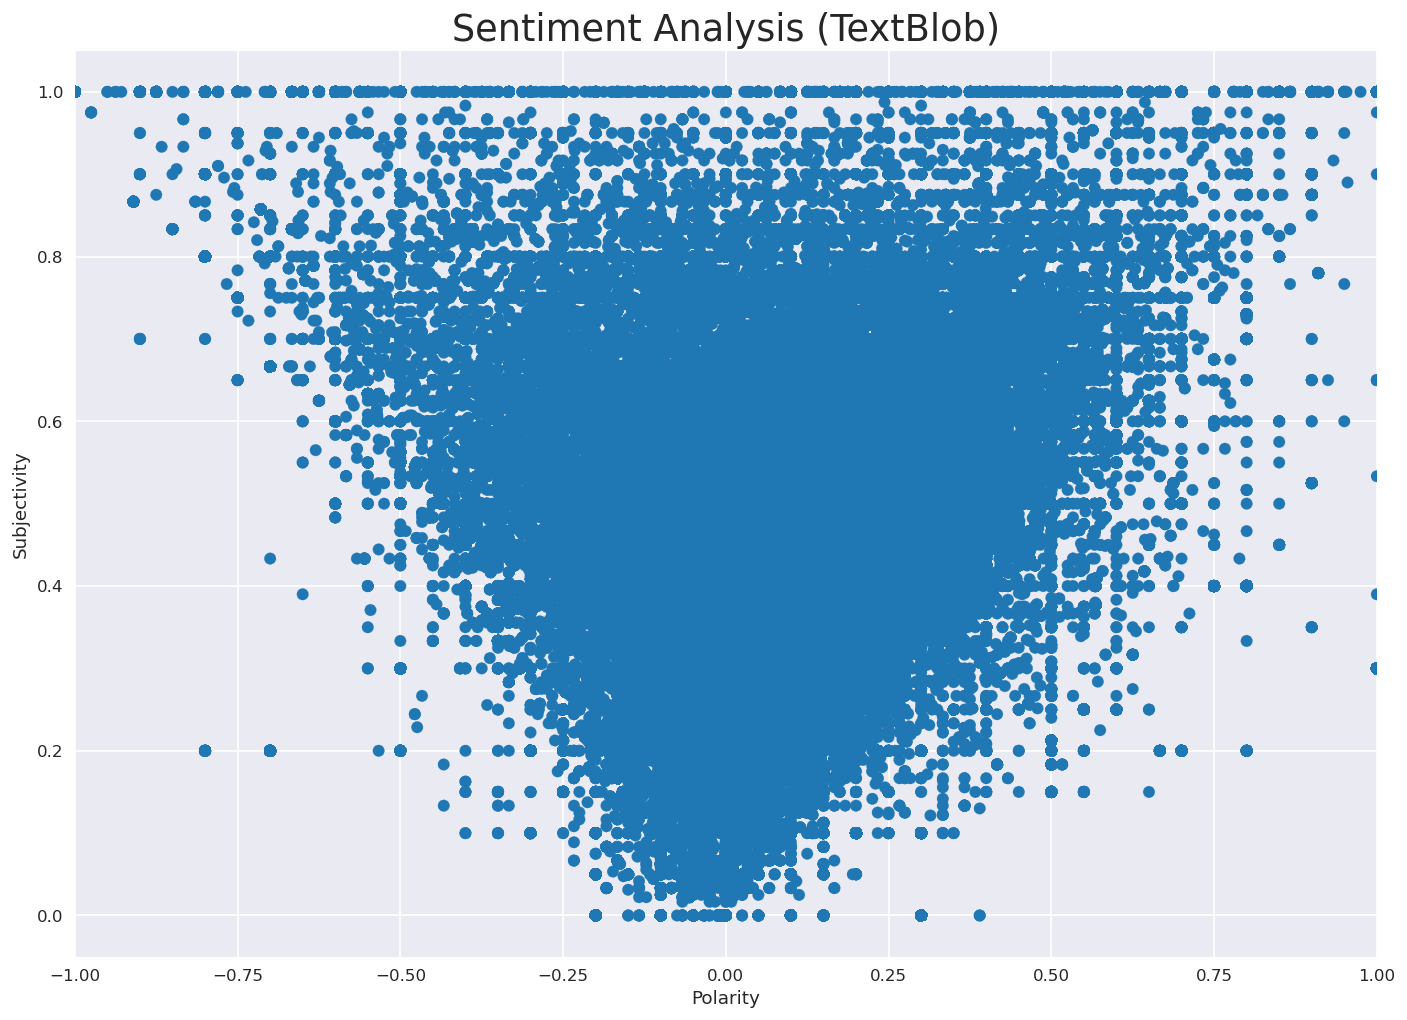

In [99]:
# with plt.style.context('seaborn'):
#     plt.figure(figsize=(14,10))
#     plt.scatter(tweets_df['Polarity'], tweets_df['Subjectivity'], color ='tab:blue', linestyle='dotted')
#     plt.xlabel('Polarity')
#     plt.ylabel('Subjectivity')
#     plt.title('Sentiment Analysis (TextBlob)', size=22)
#     plt.axis(xmin=-1,xmax=1)
# plt.show()

In [31]:
data_shifted = data_shifted.join(tweets_groupby_df_shifted, on='Date').drop(['Polarity','Subjectivity','Compound','Lemmatized Tokens'],axis=1)
data_shifted = data_shifted.join(reddit_shifted, on='Date').drop(['Polarity','Subjectivity','Compound','Lemmatized Tokens'],axis=1)

In [32]:
data_shifted.dropna(inplace=True)
data_shifted.reset_index(drop=True,inplace=True)

In [33]:
data_shifted.head()

,Date,EUA_Carbon,EUA_Ret,CO1_BrentCrude,Rotterdam_Coal,GSCI_NonEnergyIndex,TZT1_NatGas,STOXX600,EUA_Price_L1,EUA_Ret_L1,...,Compound_L3,Polarity_L1_R,Subjectivity_L1_R,Compound_L1_R,Polarity_L2_R,Subjectivity_L2_R,Compound_L2_R,Polarity_L3_R,Subjectivity_L3_R,Compound_L3_R
0,2014-01-06,95.35,-0.018730,112.83,79.50,31.23,54.493,327.64,97.17,-0.004202,...,0.049824,0.032912,0.327708,-0.235814,0.138461,0.381615,0.030784,0.034062,0.364277,-0.052544
1,2014-01-07,96.16,0.008495,112.67,79.75,31.25,54.652,326.98,95.35,-0.018730,...,0.011218,0.012939,0.383871,0.012288,0.032912,0.327708,-0.235814,0.138461,0.381615,0.030784
2,2014-01-08,93.94,-0.023087,113.29,79.60,31.26,54.429,329.40,96.16,0.008495,...,-0.006963,0.096236,0.332602,0.114217,0.012939,0.383871,0.012288,0.032912,0.327708,-0.235814
3,2014-01-09,92.53,-0.015010,113.09,81.90,31.00,54.710,329.75,93.94,-0.023087,...,0.001301,0.046432,0.382392,0.006161,0.096236,0.332602,0.114217,0.012939,0.383871,0.012288
4,2014-01-10,92.93,0.004323,112.33,84.00,30.85,54.648,328.41,92.53,-0.015010,...,0.032520,0.034769,0.298512,0.027295,0.046432,0.382392,0.006161,0.096236,0.332602,0.114217


# Data Exploration

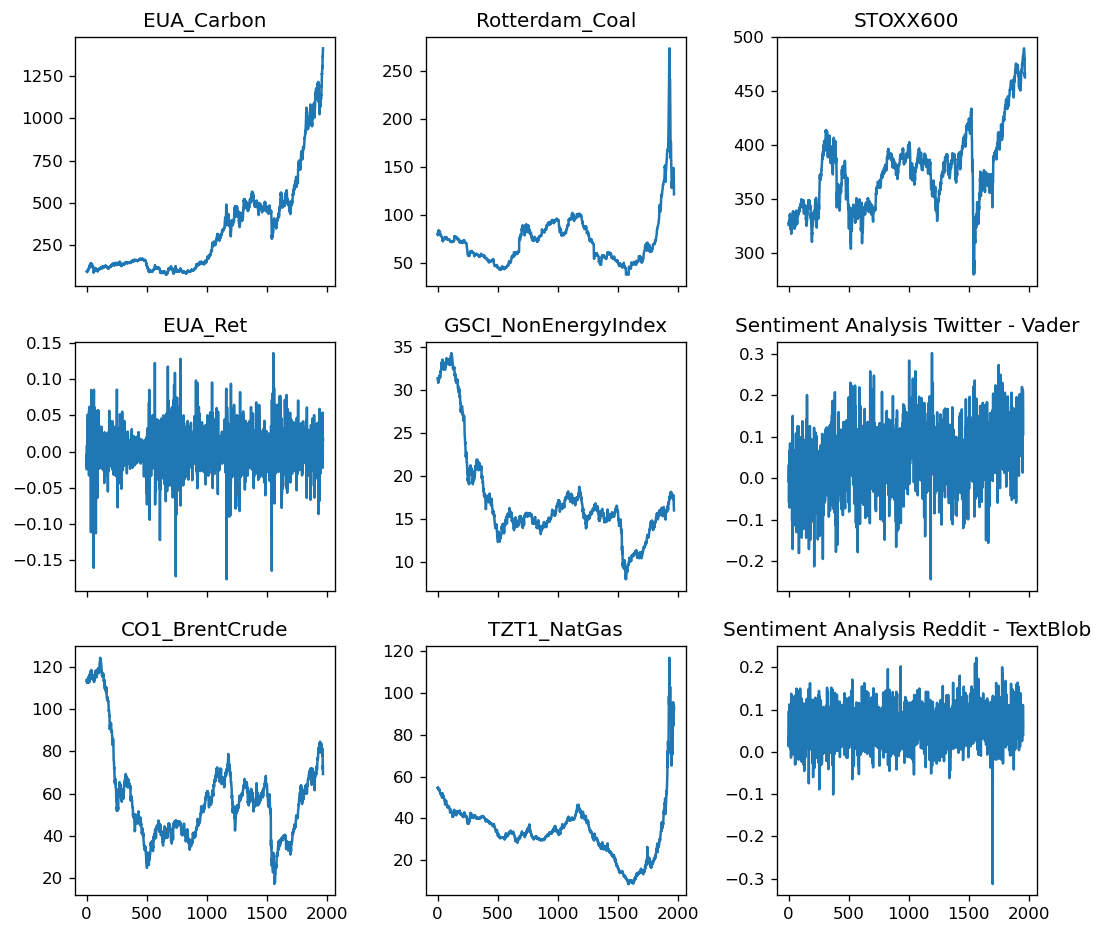

In [34]:
plt.rcParams.update({'figure.figsize':(9,8), 'figure.dpi':120})
fig, axes = plt.subplots(3, 3, sharex=True)
i = 0
j = 0
for col in columns_df:
    if i == 3:
        i = 0
        j += 1
    axes[i, j].plot(data[col])
    axes[i,j].set_title(f"{col}")
    i += 1
axes[1,2].plot(data_shifted['Compound_L1'])
axes[1,2].set_title('Sentiment Analysis Twitter - Vader')

axes[2,2].plot(data_shifted['Polarity_L1_R'])
axes[2,2].set_title('Sentiment Analysis Reddit - TextBlob')

plt.show
fig.tight_layout(pad=1.5)

<AxesSubplot:>

<Figure size 2280x1800 with 0 Axes>

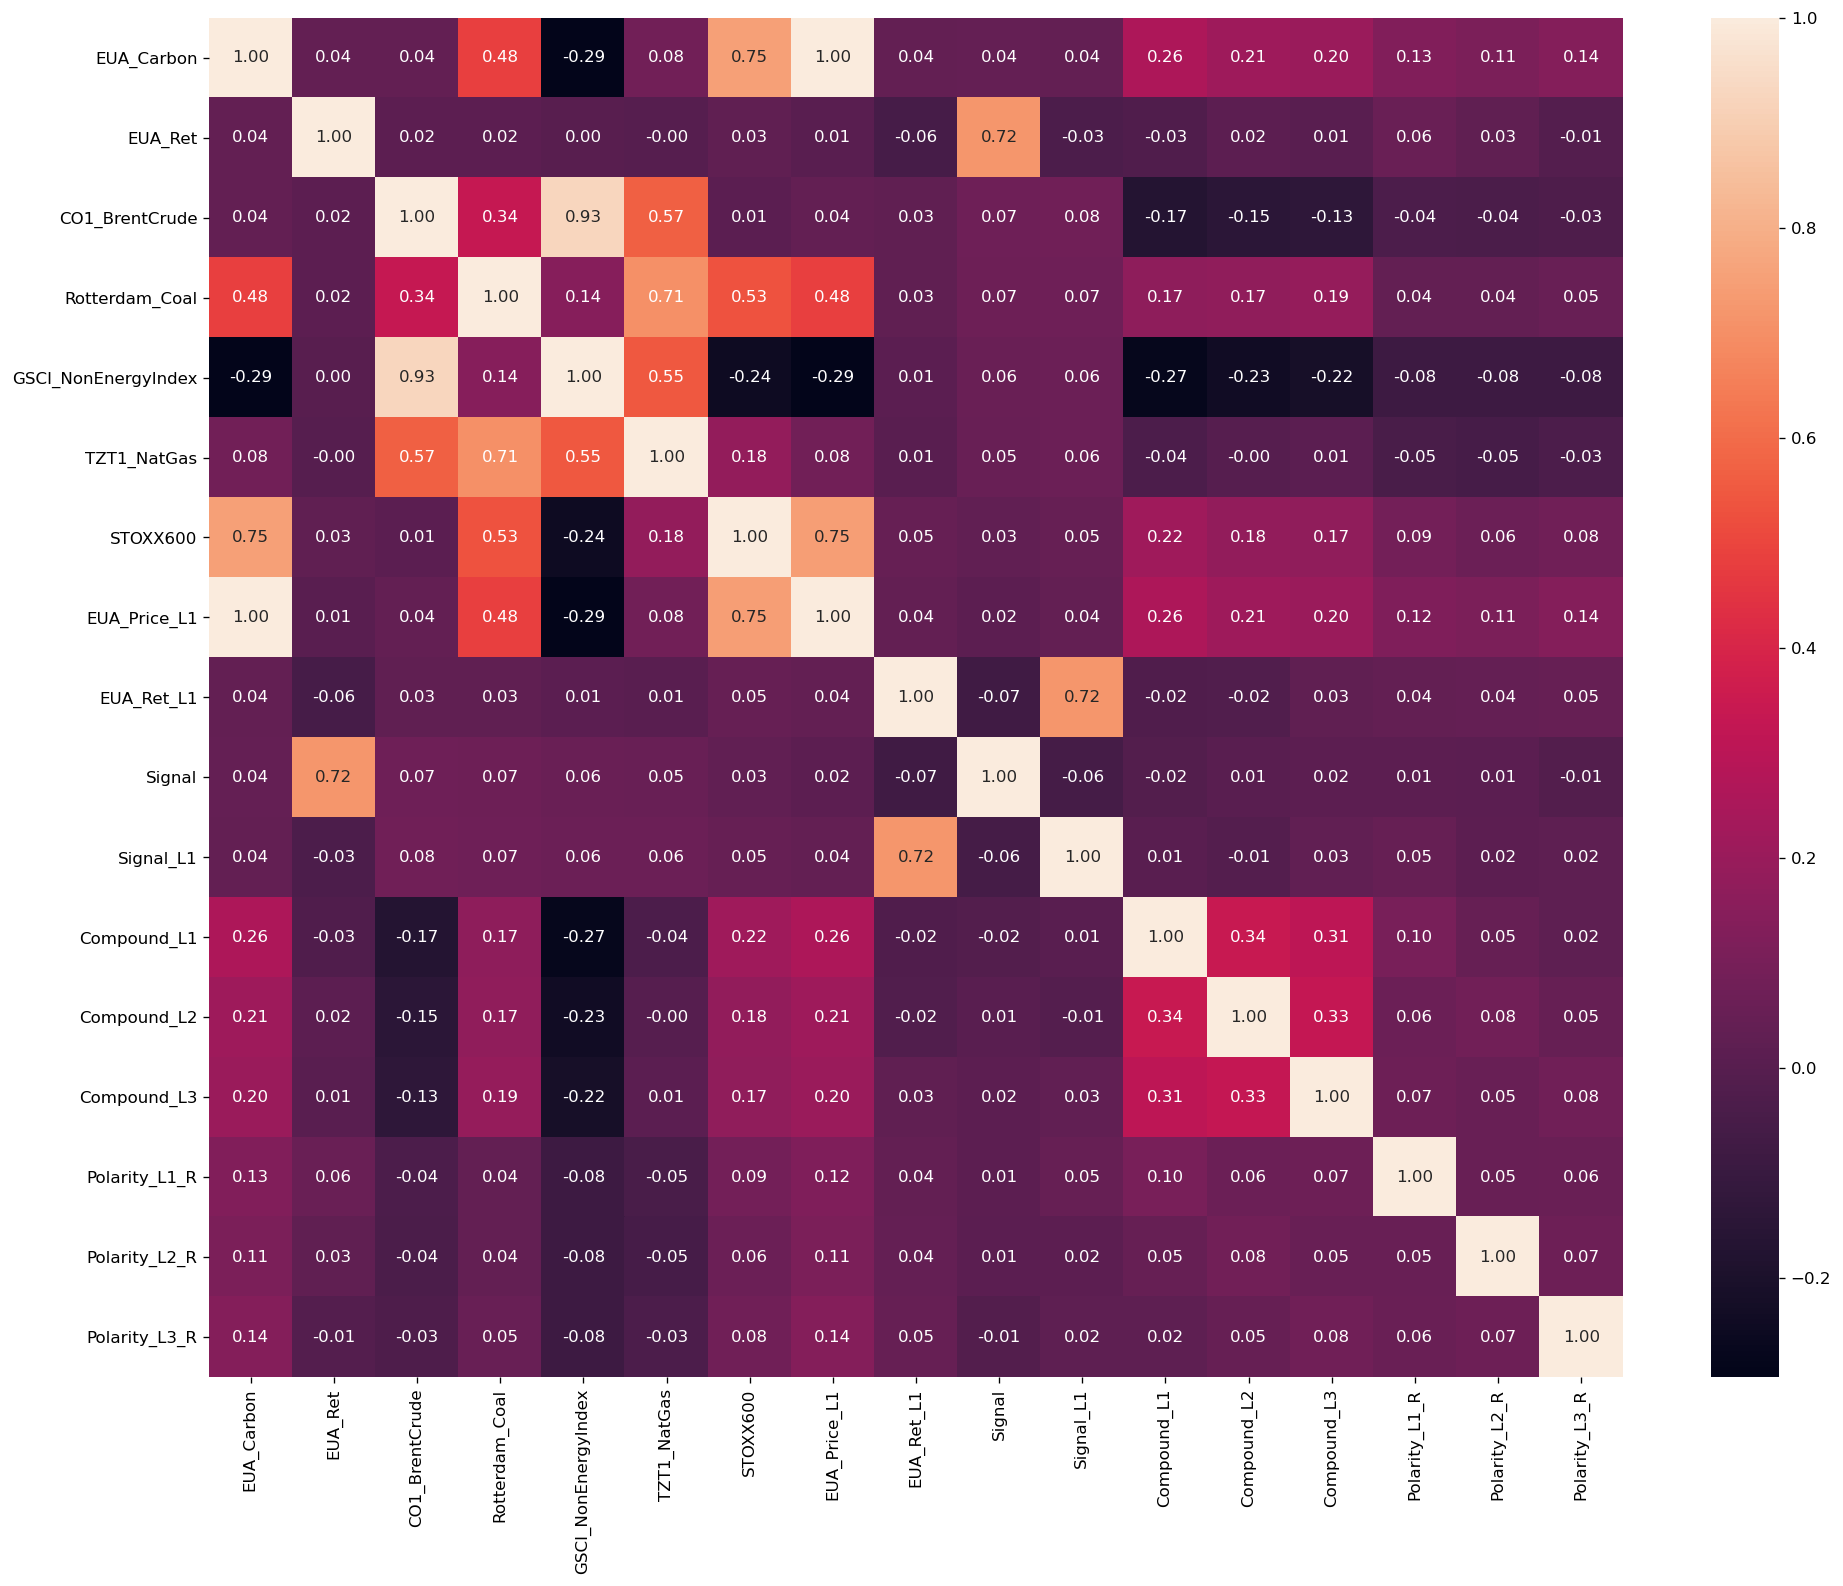

In [35]:
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
#columns =data.columns.drop(['EUA_Carbon','Date','CO1_BrentCrude','Rotterdam_Coal','Electricity','GSCI_NonEnergyIndex',
#                          'TZT1_NatGas','STOXX600'])   

columns =data_shifted.columns.drop(['Date','Compound_L1_R','Compound_L2_R','Compound_L3_R','Subjectivity_L1_R','Subjectivity_L2_R','Subjectivity_L3_R','Polarity_L1','Polarity_L2','Polarity_L3','Subjectivity_L1','Subjectivity_L2','Subjectivity_L3']) 
# 'Polarity_L1_R','Polarity_L2_R','Polarity_L3_R','Subjectivity_L1_R','Subjectivity_L2_R','Subjectivity_L3_R' 
#,'Polarity_L1','Polarity_L2','Polarity_L3','Subjectivity_L1','Subjectivity_L2','Subjectivity_L3'
#,'Compound_L1_R','Compound_L2_R','Compound_L3_R','Subjectivity_L1_R','Subjectivity_L2_R','Subjectivity_L3_R','Polarity_L1','Polarity_L2','Polarity_L3','Subjectivity_L1','Subjectivity_L2','Subjectivity_L3'
data1=data_shifted.copy()
corr_data= data1[columns]


f = plt.figure(figsize=(19, 15))
f,ax = plt.subplots(figsize=(19,15))
corrMatrix = corr_data.corr()
# mask = np.zeros_like(corrMatrix, dtype=np.bool) 
# mask[np.triu_indices_from(mask)] = True
sns.heatmap(corrMatrix, annot=True, fmt= '.2f',ax=ax)

In [30]:
# with plt.style.context('seaborn'):
#     plt.figure(figsize=(14,10))
#     plt.scatter(tweets_groupby_df_shifted['Compound'], tweets_groupby_df_shifted['Subjectivity'], color ='tab:blue', linestyle='dotted')
#     plt.xlabel('Polarity')
#     plt.ylabel('Subjectivity')
#     plt.title('Sentiment Analysis (TextBlob)', size=22)
#     plt.axis(xmin=-1,xmax=1)
# plt.show()

In [36]:
# data_shifted
data_shifted.dropna(inplace = True)
data_shifted.reset_index(drop=True, inplace=True)

In [52]:
X = data_shifted.drop(['EUA_Carbon','Date','Signal','EUA_Ret','Compound_L1_R','Compound_L2_R','Compound_L3_R','Subjectivity_L1_R','Subjectivity_L2_R','Subjectivity_L3_R','Polarity_L1','Subjectivity_L1','Polarity_L2','Subjectivity_L2','Polarity_L3','Subjectivity_L3'], axis=1)
# ,,'Polarity_L1_R','Subjectivity_L1_R','Polarity_L2_R','Subjectivity_L2_R','Polarity_L3_R','Subjectivity_L3_R'
# ,'Polarity_L1','Subjectivity_L1','Polarity_L2','Subjectivity_L2','Polarity_L3','Subjectivity_L3'
#
Y = data_shifted['Signal']

In [53]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
 
for x in X.columns:
    model = ols('Signal' + '~' + x, data = data_shifted).fit() #Oridnary least square method
    result_anova = sm.stats.anova_lm(model) # ANOVA Test
    print(result_anova)

                    df       sum_sq    mean_sq          F    PR(>F)
CO1_BrentCrude     1.0    10.334146  10.334146  10.439568  0.001254
Residual        1951.0  1931.298214   0.989902        NaN       NaN
                    df       sum_sq   mean_sq         F    PR(>F)
Rotterdam_Coal     1.0     8.256270  8.256270  8.331531  0.003939
Residual        1951.0  1933.376091  0.990967       NaN       NaN
                         df       sum_sq   mean_sq         F    PR(>F)
GSCI_NonEnergyIndex     1.0     6.424354  6.424354  6.476779  0.011006
Residual             1951.0  1935.208007  0.991906       NaN       NaN
                 df      sum_sq   mean_sq         F    PR(>F)
TZT1_NatGas     1.0     5.35883  5.358830  5.399587  0.020244
Residual     1951.0  1936.27353  0.992452       NaN       NaN
              df       sum_sq   mean_sq         F    PR(>F)
STOXX600     1.0     2.291054  2.291054  2.304827  0.129135
Residual  1951.0  1939.341306  0.994024       NaN       NaN
                  d

Considering significance value as 0.05. we say that if the p value is less than 0.05, we assume and claim that there is considerable differences in the mean of the groups formed by each level of the categorical data. That is, we reject the NULL hypothesis. All variables except EUA_Price_copy are significant 

In [54]:
prop = 0.3

training_size = int(len(X) * (1 - prop))

X_TRAIN,X_TEST,Y_TRAIN,Y_TEST = train_test_split(X,Y,test_size=0.3,stratify=Y,random_state=0)

In [55]:
scalar =StandardScaler()
columns_ =X_TRAIN.columns 
# scalar.fit(X_TRAIN)
#X_TRAIN[columns_] = scalar.transform(X_TRAIN[columns_])
X_TRAIN_scaled = X_TRAIN.copy()
X_TRAIN_scaled[columns_]= scalar.fit_transform(X_TRAIN[columns_])

In [56]:
cls= SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [57]:
cls.fit(X_TRAIN_scaled,Y_TRAIN)

SVC(C=1, decision_function_shape='ovo', gamma='auto', probability=True)

In [58]:
#scalar =StandardScaler()
#columns_ =X_TEST.columns 
X_TEST_scaled = X_TEST.copy()
X_TEST_scaled[columns_] = scalar.transform(X_TEST[columns_])
#X_TEST[columns_]= scalar.transform(X_TEST[columns_])

In [59]:
len(cls.predict(X_TEST_scaled))

586

In [60]:
testing_size = len(X)-training_size

In [61]:
results_df = pd.DataFrame(Y_TEST)
results_df['Predicted'] = cls.predict(X_TEST_scaled)

# Prediction

In [62]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def cm2df(cm, labels):
    df = pd.DataFrame()
    # rows
    for i, row_label in enumerate(labels):
        rowdata={}
        # columns
        for j, col_label in enumerate(labels): 
            rowdata[col_label]=cm[i,j]
        df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
    return df[labels]



def model_eval(y_test,y_pred): 
    data = {'y_Actual':    Y_TEST,
        'y_Predicted': y_pred.tolist()
        }
    f,ax = plt.subplots(figsize=(5,5))
    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
    sns.heatmap(confusion_matrix, annot=True, fmt= 'd',ax=ax)
    plt.show()

#     cm_df=cm2df(confusion,[0,1]) 
#     new_names={0:'y_Actual',1:'y_Predicted'} 
#     cm_df=cm_df.rename(index=new_names,columns=new_names)
#     print('\n')
#     print('confusion matrix')
#     print(cm_df)
#     print('\n')
#     print(classification_report(y_test,y_pred,target_names=['y_Actual','y_Predicted']))
    
# corrMatrix = corr_data.corr()
# mask = np.zeros_like(corrMatrix, dtype=np.bool) 
# mask[np.triu_indices_from(mask)] = True
# sns.heatmap(corrMatrix, annot=True)

In [63]:
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import roc_curve
def plot_roc_curve(model,X_test,y_test): 
    probabilities=model.predict_proba(X_test)[:,1] 
    auc=roc_auc_score(y_test,probabilities) 
    print('AUC:%.3f' % auc)
    fpr,tpr,thresholds=roc_curve(y_test,probabilities)
    plt.plot(fpr,tpr,marker='.') 
    plt.xlabel('False positive Rate') 
    plt.ylabel('True positive Rate') 
    plt.title('ROC curve')
    plt.show()

In [64]:
y_pred=cls.predict(X_TEST_scaled)

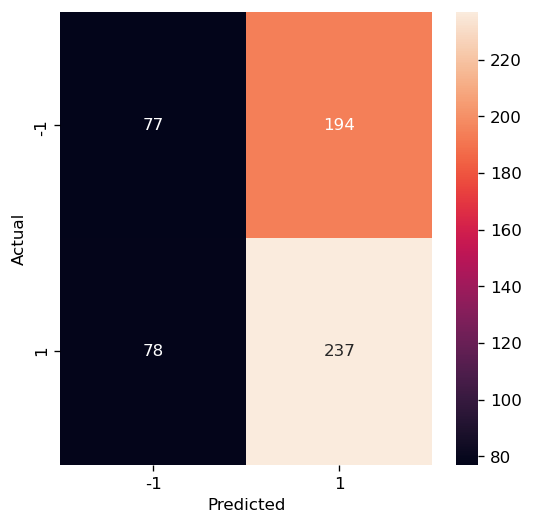

AUC:0.532


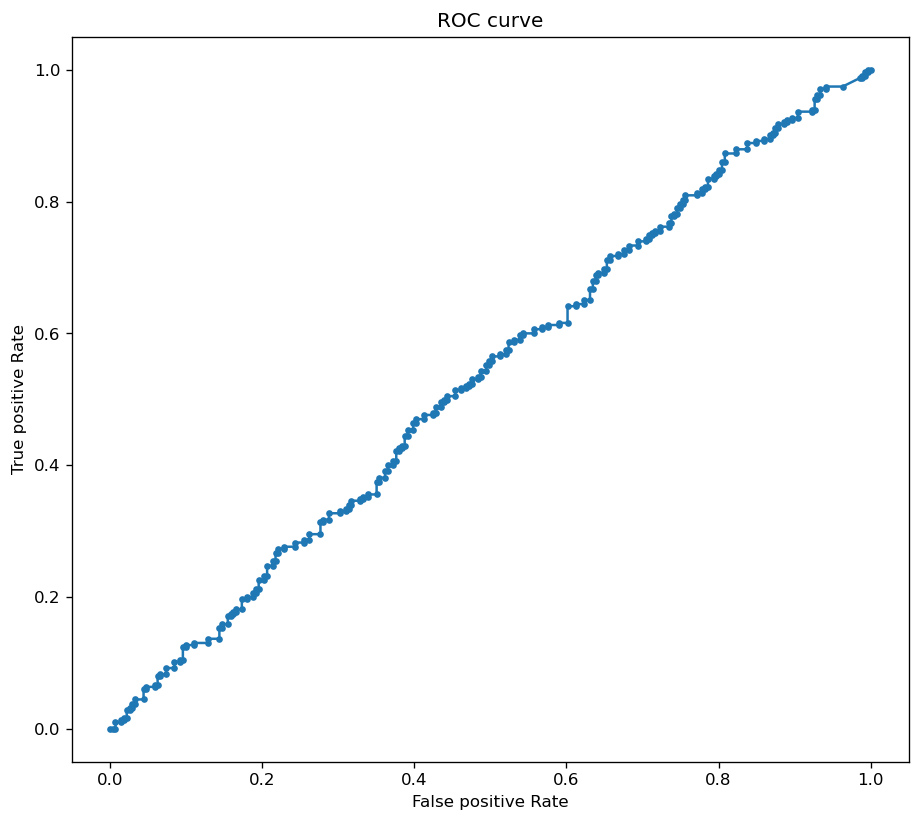

Accuracy:  0.5358361774744027
F1_score:  0.6353887399463806


In [65]:
model_eval(results_df['Signal'],results_df['Predicted']) 
plot_roc_curve(cls,X_TEST_scaled,Y_TEST)
from sklearn.metrics import accuracy_score 
print("Accuracy: ",accuracy_score(Y_TEST,y_pred))
print("F1_score: ", f1_score(Y_TEST,y_pred))

In [74]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1,1, 10], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_TRAIN_scaled,Y_TRAIN)
print(grid.best_estimator_)
grid_predictions = grid.predict(X_TEST_scaled)
print(confusion_matrix(Y_TEST,grid_predictions))
print(classification_report(Y_TEST,grid_predictions))

#     cls= SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
#     decision_function_shape='ovo', degree=3, gamma='auto', kernel='rbf',
#     max_iter=-1, probability=True, random_state=None, shrinking=True,
#     tol=0.001, verbose=False)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   1.7s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   1.3s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   1.6s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   1.6s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   1.5s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, k

[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ...................C=1, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ...................C=1, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ...................

In [75]:
print(grid.best_estimator_)

SVC(C=1, gamma=0.01)


In [76]:
print(confusion_matrix(Y_TEST,grid_predictions))
print(classification_report(Y_TEST,grid_predictions))

[[ 27 244]
 [ 22 293]]
              precision    recall  f1-score   support

          -1       0.55      0.10      0.17       271
           1       0.55      0.93      0.69       315

    accuracy                           0.55       586
   macro avg       0.55      0.51      0.43       586
weighted avg       0.55      0.55      0.45       586



# Logistic Regression

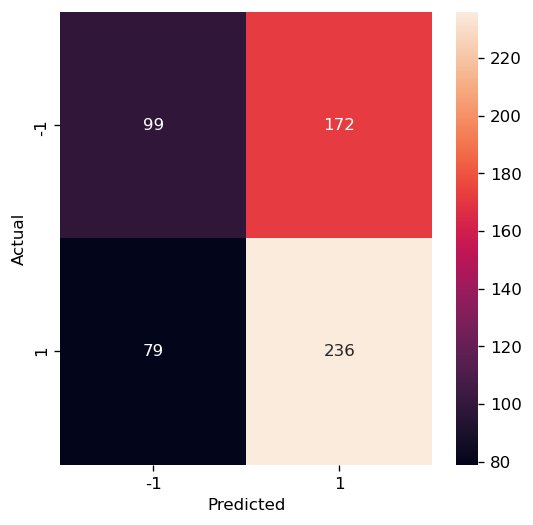

AUC:0.555


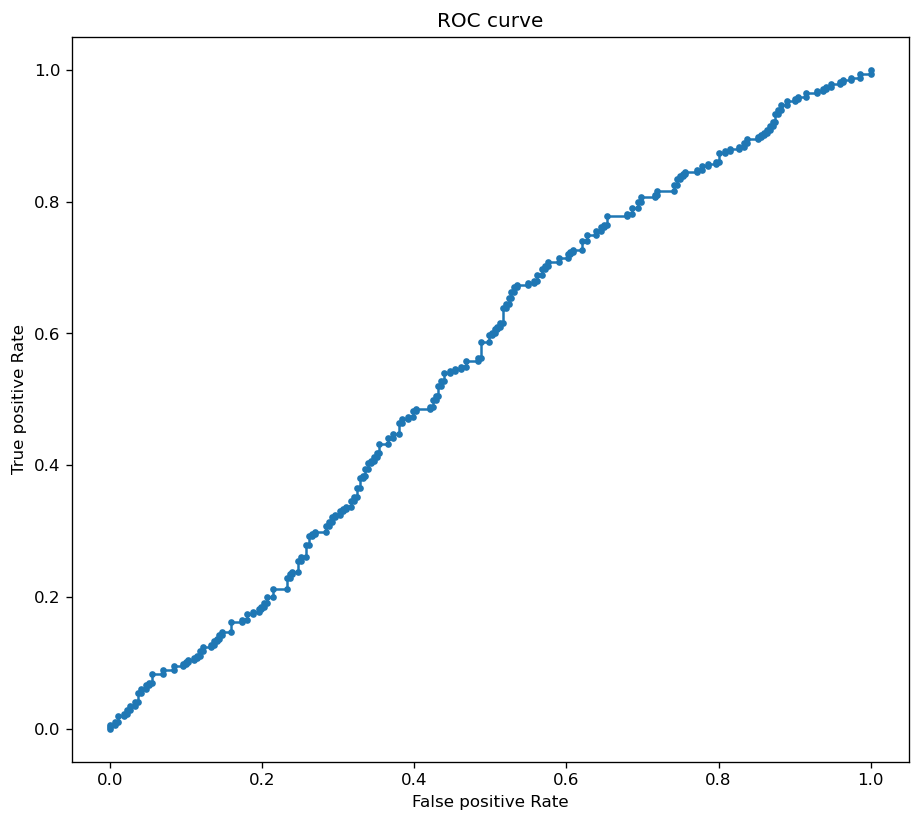

Accuracy:  0.5716723549488054
F1_score:  0.65283540802213


In [77]:
from sklearn.linear_model import LogisticRegression 
logreg=LogisticRegression() 
logreg.fit(X_TRAIN_scaled,Y_TRAIN)
y_pred=logreg.predict(X_TEST_scaled)
model_eval(Y_TEST,y_pred) 
plot_roc_curve(logreg,X_TEST_scaled,Y_TEST)
from sklearn.metrics import accuracy_score 
print("Accuracy: ",accuracy_score(Y_TEST,y_pred))
print("F1_score: ",f1_score(Y_TEST,y_pred))

# Logistic Regression with Ada Boost

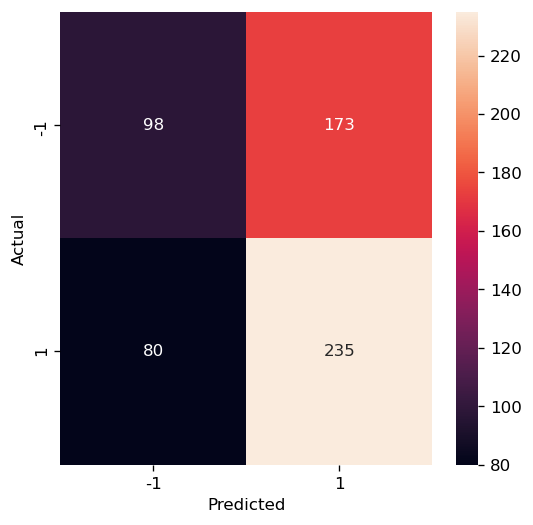

AUC:0.554


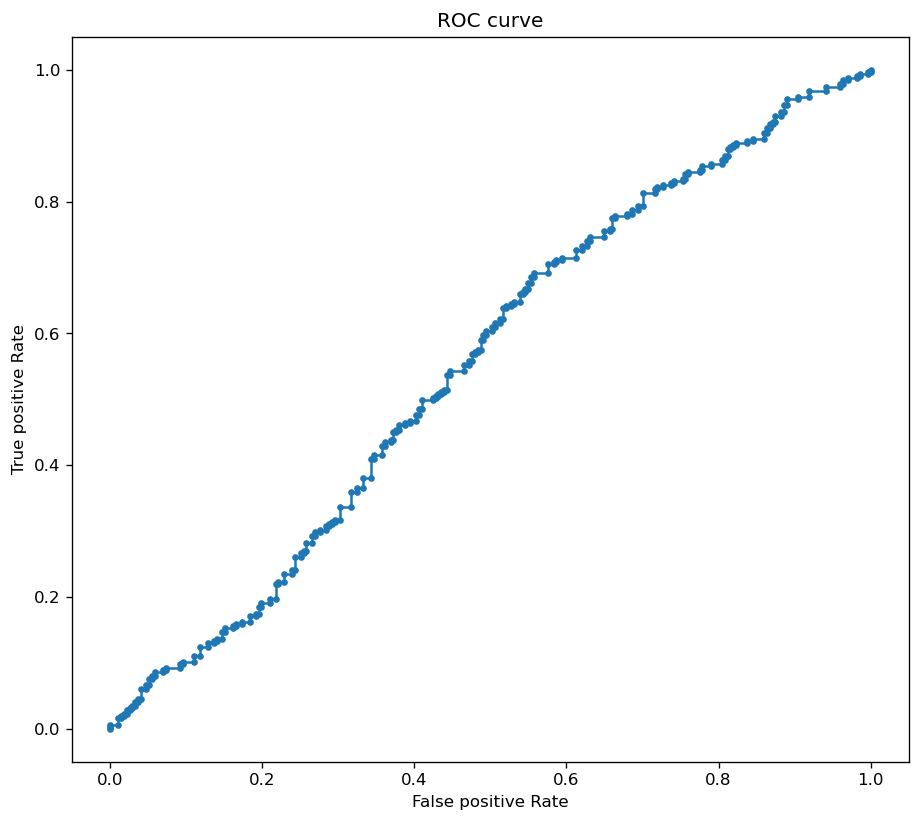

Accuracy:  0.568259385665529
F1-score:  0.6500691562932226


In [78]:
from sklearn.ensemble import AdaBoostClassifier 
AB=AdaBoostClassifier(LogisticRegression()) 
AB.fit(X_TRAIN_scaled,Y_TRAIN) 
y_pred=AB.predict(X_TEST_scaled)
model_eval(Y_TEST,y_pred) 
plot_roc_curve(AB,X_TEST_scaled,Y_TEST)
from sklearn.metrics import accuracy_score 
print("Accuracy: ",accuracy_score(Y_TEST,y_pred))
print("F1-score: ",f1_score(Y_TEST,y_pred))

# DecisionTreeClassifier

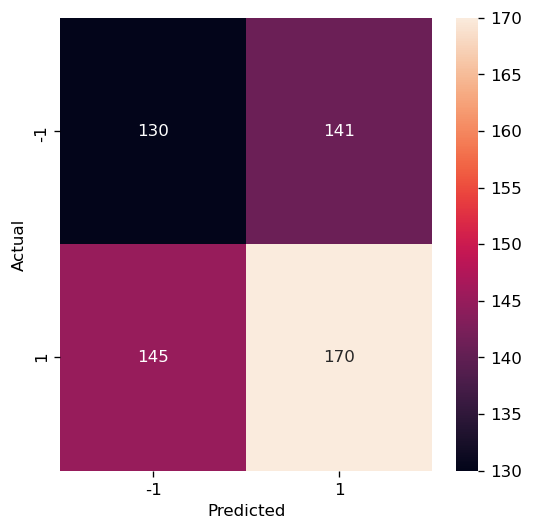

AUC:0.510


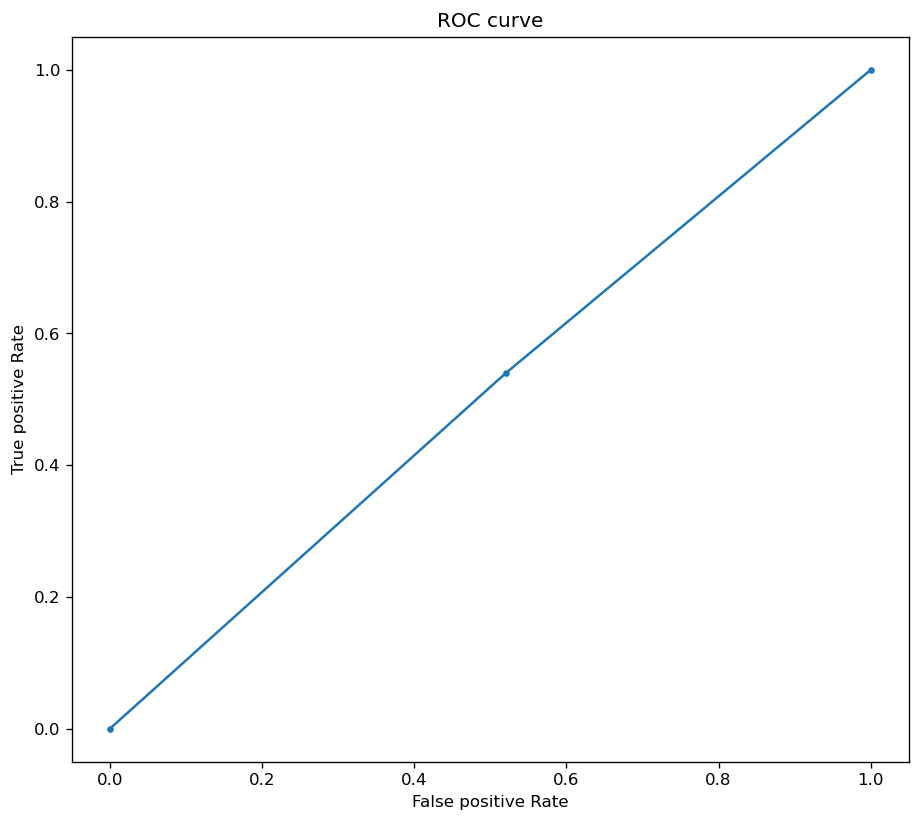

Accuracy:  0.5119453924914675
F1-score:  0.5431309904153354


In [79]:
from sklearn.tree import DecisionTreeClassifier
CART=DecisionTreeClassifier() 
CART.fit(X_TRAIN_scaled,Y_TRAIN)
y_pred=CART.predict(X_TEST_scaled)
model_eval(Y_TEST,y_pred) 
plot_roc_curve(CART,X_TEST_scaled,Y_TEST)
print("Accuracy: ",accuracy_score(Y_TEST,y_pred))
print("F1-score: ",f1_score(Y_TEST,y_pred))

# RandomForestClassifier

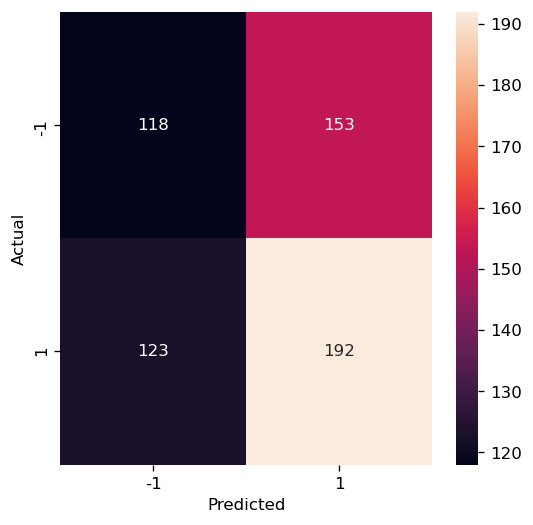

AUC:0.529


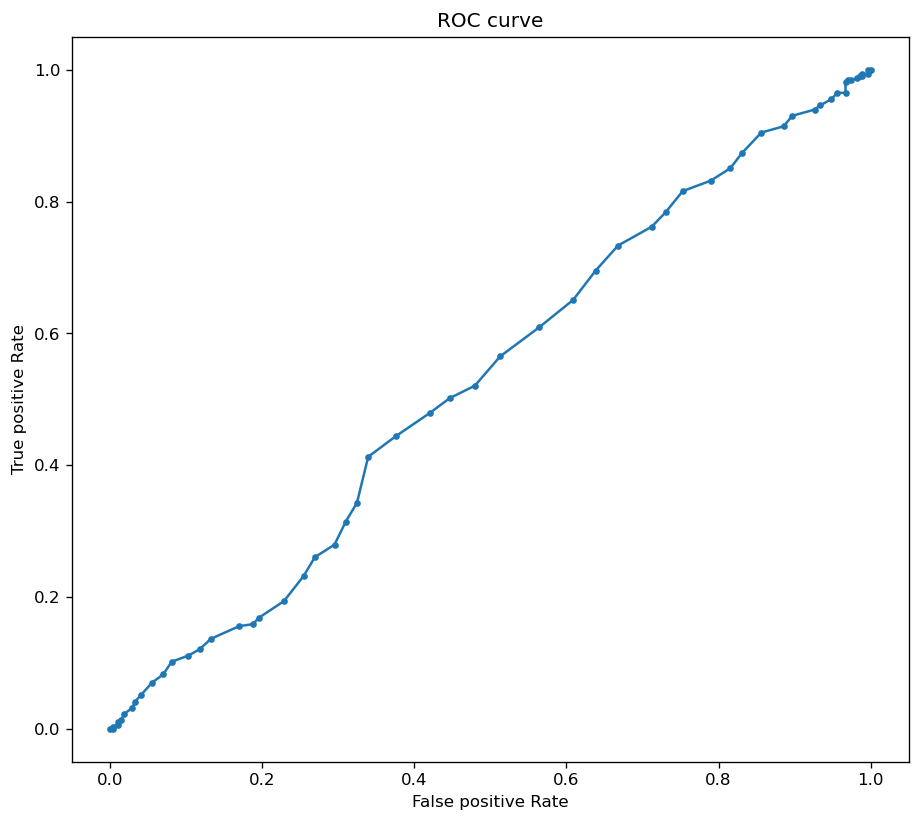

Accuracy:  0.5290102389078498
F1-score:  0.5818181818181819


In [80]:
from sklearn.ensemble import RandomForestClassifier
RF=RandomForestClassifier()
RF.fit(X_TRAIN_scaled,Y_TRAIN)
y_pred=RF.predict(X_TEST_scaled)
model_eval(Y_TEST,y_pred) 
plot_roc_curve(RF,X_TEST_scaled,Y_TEST)
print("Accuracy: ",accuracy_score(Y_TEST,y_pred))
print("F1-score: ",f1_score(Y_TEST,y_pred))

# ADA Boost

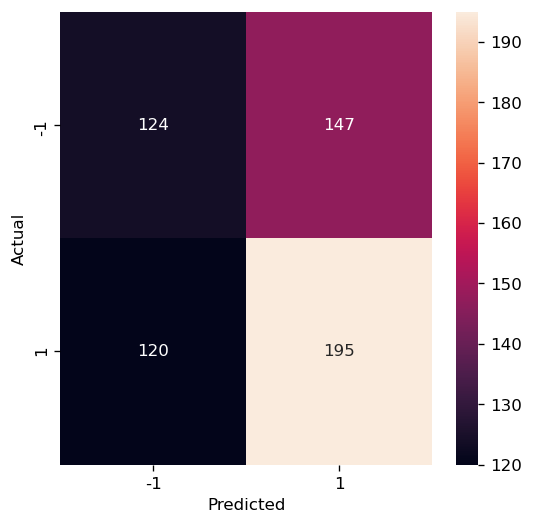

AUC:0.523


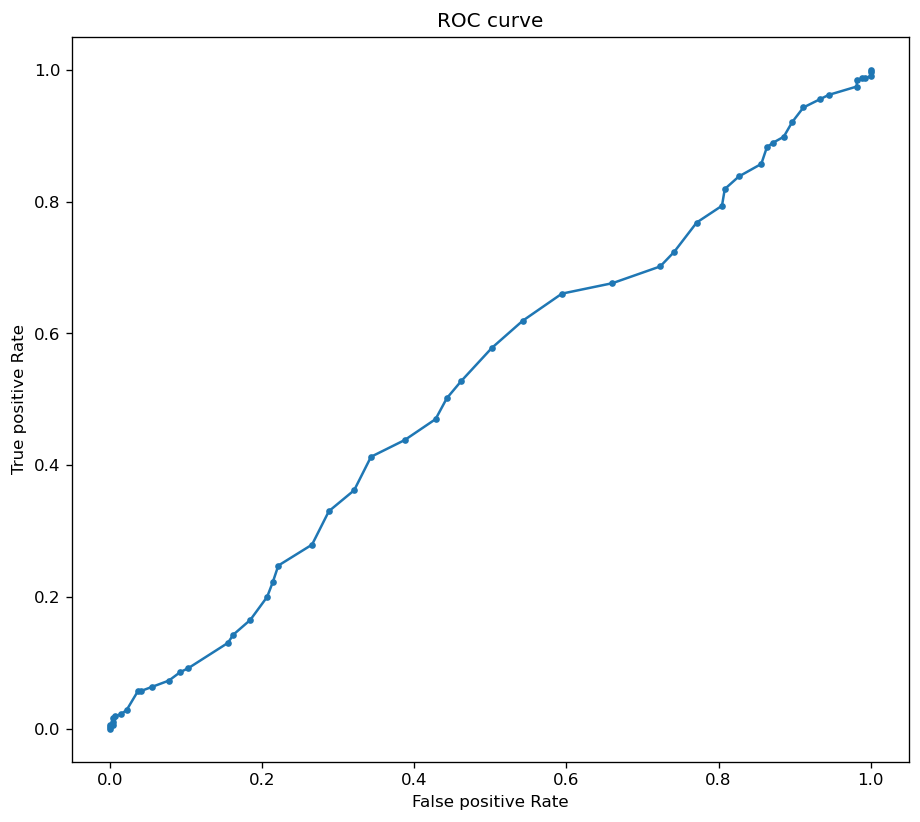

Accuracy:  0.5443686006825939
F1-score:  0.593607305936073


In [81]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
AB=AdaBoostClassifier(RandomForestClassifier()) 
AB.fit(X_TRAIN_scaled,Y_TRAIN)
y_pred=AB.predict(X_TEST_scaled)
model_eval(Y_TEST,y_pred) 
plot_roc_curve(AB,X_TEST_scaled,Y_TEST)
print("Accuracy: ",accuracy_score(Y_TEST,y_pred))
print("F1-score: ",f1_score(Y_TEST,y_pred))

# MLPClassifier 

In [ ]:
from sklearn.neural_network import MLPClassifier 
ANN=MLPClassifier(max_iter = 1000) 
ANN.fit(X_TRAIN_scaled,Y_TRAIN)
y_pred=ANN.predict(X_TEST_scaled) 
model_eval(Y_TEST,y_pred) 
plot_roc_curve(ANN,X_TEST_scaled,Y_TEST) 
print("Accuracy: ",accuracy_score(Y_TEST,y_pred))
print("F1-score: ",f1_score(Y_TEST,y_pred))

# XGBoost

[14:50:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


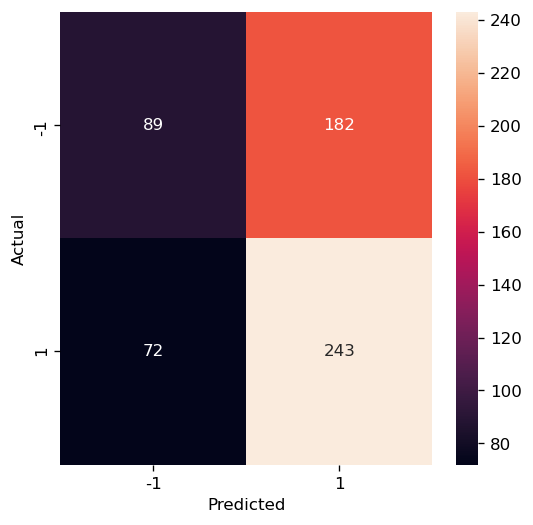

AUC:0.548


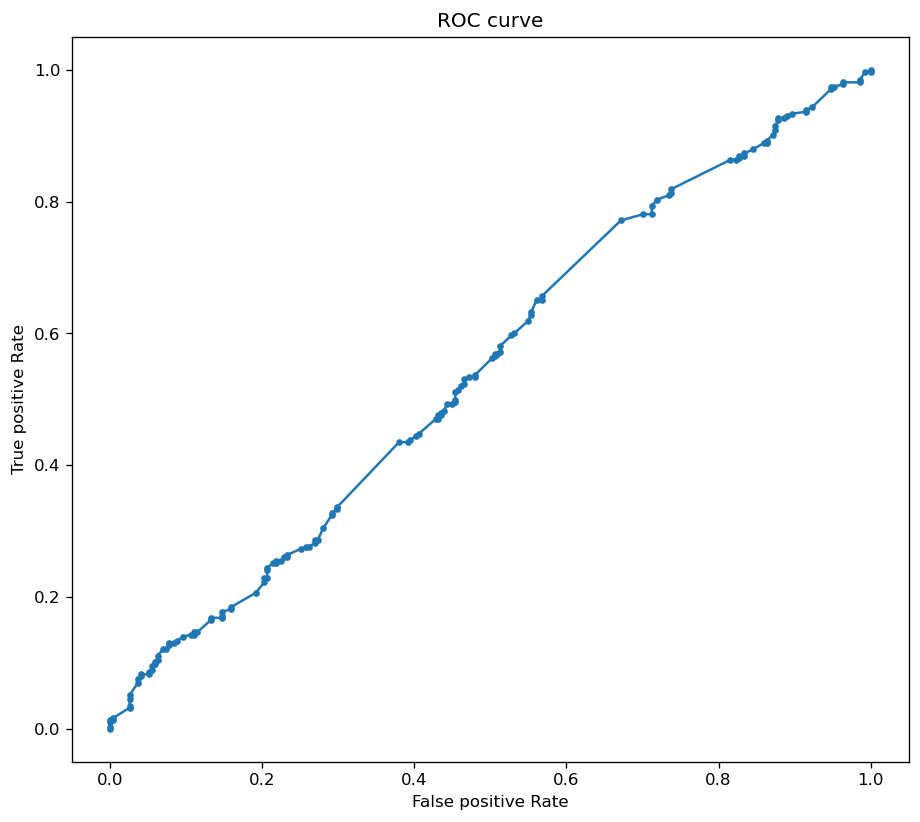

Accuracy:  0.5665529010238908
F1-score:  0.6567567567567568


In [83]:
import xgboost
from xgboost import XGBClassifier

XGB = XGBClassifier(n_estimators=5, max_depth=3)

XGB.fit(X_TRAIN_scaled,Y_TRAIN)
y_pred = XGB.predict(X_TEST_scaled)
model_eval(Y_TEST,y_pred) 
plot_roc_curve(XGB,X_TEST_scaled,Y_TEST) 
print("Accuracy: ",accuracy_score(Y_TEST,y_pred))
print("F1-score: ",f1_score(Y_TEST,y_pred))

# kNN

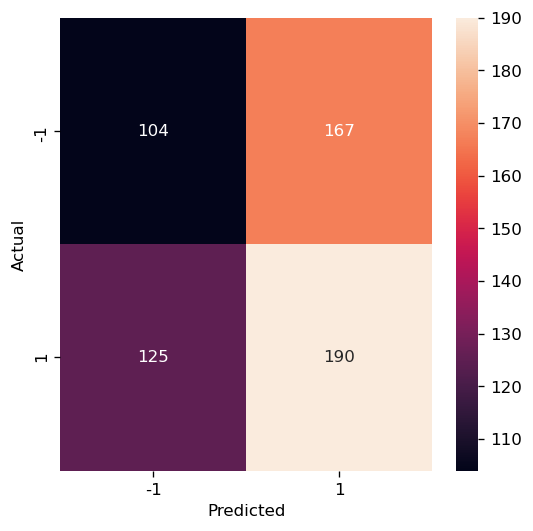

AUC:0.504


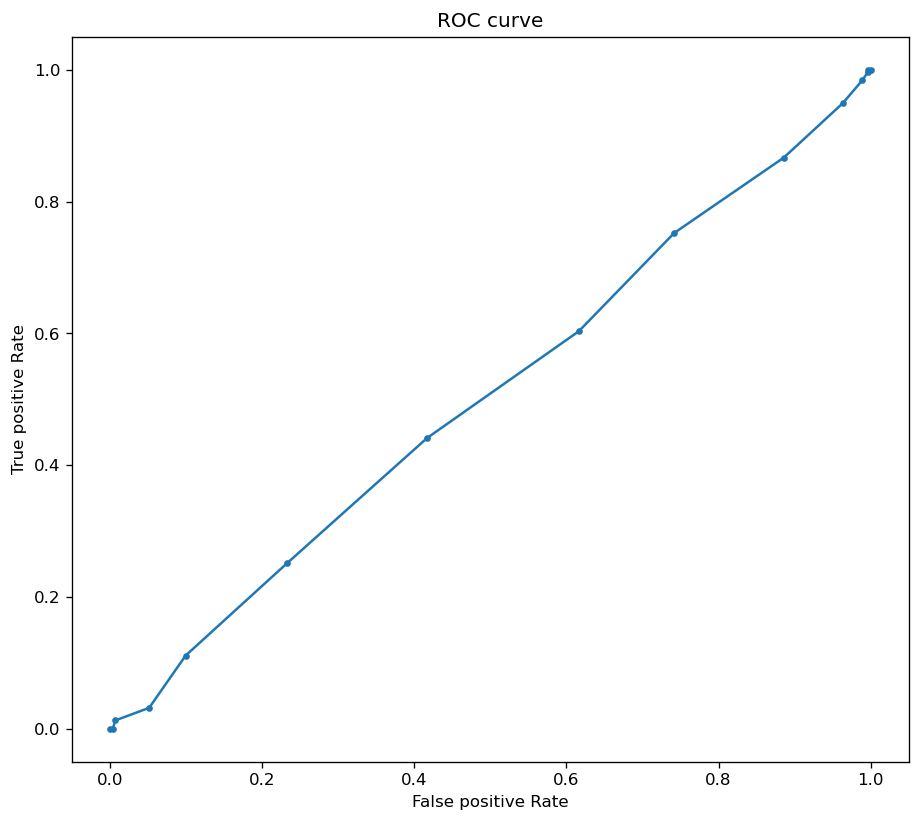

Accuracy:  0.5017064846416383
F1-score:  0.5654761904761905


In [84]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_TRAIN_scaled,Y_TRAIN)
y_pred = knn.predict(X_TEST_scaled)
model_eval(Y_TEST,y_pred) 
plot_roc_curve(knn,X_TEST_scaled,Y_TEST) 
print("Accuracy: ",accuracy_score(Y_TEST,y_pred))
print("F1-score: ",f1_score(Y_TEST,y_pred))

# Support Vector Regression

In [63]:
X_SVR = data_shifted.drop(['EUA_Carbon','Date','Signal','EUA_Ret','Polarity_L1_R','Subjectivity_L1_R','Polarity_L2_R','Subjectivity_L2_R','Polarity_L3_R','Subjectivity_L3_R'], axis=1)
Y_SVR = data_shifted['EUA_Ret']
# ,'Polarity_L1','Subjectivity_L1','Polarity_L2','Subjectivity_L2','Polarity_L3','Subjectivity_L3'

In [64]:
prop = 0.3

training_size = int(len(X) * (1 - prop))

X_SVR_TRAIN,X_SVR_TEST,Y_SVR_TRAIN,Y_SVR_TEST = train_test_split(X_SVR,Y_SVR,test_size=0.3,random_state=0)


In [65]:
X_SVR_TRAIN

,CO1_BrentCrude,Rotterdam_Coal,GSCI_NonEnergyIndex,TZT1_NatGas,STOXX600,EUA_Price_L1,EUA_Ret_L1,Signal_L1,Compound_L1_R,Compound_L2_R,Compound_L3_R
616,42.93,56.55,15.23,32.927,318.76,90.28,-0.025475,-1,-0.006523,0.012796,0.021239
618,40.89,56.45,14.85,32.902,327.35,89.49,-0.006550,-1,-0.113450,-0.090477,-0.184947
1702,36.90,51.50,11.18,14.466,384.42,494.36,-0.011991,-1,0.093198,0.111047,0.086209
96,118.55,74.80,33.41,45.258,344.47,105.45,0.015505,1,0.076162,-0.161237,-0.076407
811,45.54,75.45,15.17,30.614,380.58,96.82,0.004044,1,0.027611,0.059253,0.124916
...,...,...,...,...,...,...,...,...,...,...,...
835,42.67,74.20,14.73,30.475,391.51,94.86,0.018904,1,-0.148894,-0.057438,-0.026490
1216,52.66,88.60,15.12,41.679,357.40,380.12,-0.011391,-1,-0.000728,-0.075592,-0.006234
1653,40.06,49.00,11.28,13.282,368.80,557.95,0.040544,1,-0.050305,0.038263,0.044382
559,39.03,45.60,14.33,30.172,343.99,110.34,0.012665,1,0.031292,-0.044385,-0.035821


In [66]:
Y_SVR_TRAIN

616    -0.002215
618    -0.026372
1702   -0.004106
96      0.005785
811    -0.018178
          ...   
835     0.012439
1216   -0.016048
1653   -0.029142
559    -0.023201
684     0.016581
Name: EUA_Ret, Length: 1368, dtype: float64

In [67]:
scalar =StandardScaler()
columns_ =X_SVR_TRAIN.columns 
# scalar.fit(X_TRAIN)
#X_TRAIN[columns_] = scalar.transform(X_TRAIN[columns_])
X_SVR_TRAIN_scaled = X_SVR_TRAIN.copy()
X_SVR_TRAIN_scaled[columns_]= scalar.fit_transform(X_SVR_TRAIN[columns_])


In [68]:
from sklearn.svm import SVR

In [69]:
regressor = SVR(kernel = 'rbf')
regressor.fit(X_SVR_TRAIN,Y_SVR_TRAIN)

SVR()

In [70]:
#scalar =StandardScaler()
#columns_ =X_TEST.columns 
X_SVR_TEST_scaled = X_SVR_TEST.copy()
X_SVR_TEST_scaled[columns_] = scalar.transform(X_SVR_TEST[columns_])
#X_TEST[columns_]= scalar.transform(X_TEST[columns_])

In [71]:
Y_SVR_Pred = regressor.predict(X_SVR_TEST)


In [72]:
SVR_results = pd.DataFrame(Y_SVR_TEST)

In [73]:
SVR_results['SVR_Pred'] = Y_SVR_Pred

In [74]:
SVR_results

,EUA_Ret,SVR_Pred
1569,-0.030658,-0.007484
443,-0.005012,0.003233
1084,0.025046,-0.006623
1710,0.019340,-0.001659
1663,-0.022201,-0.003960
...,...,...
994,0.014124,0.002839
1707,0.020901,-0.001811
1463,-0.005650,-0.001554
1715,-0.009199,-0.002236


In [75]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(SVR_results['EUA_Ret'],SVR_results['SVR_Pred']))

0.02264798709041107


In [76]:
SVR_results.loc[SVR_results['SVR_Pred']>=0,'SVR_Pred_Signal']=1
SVR_results.loc[SVR_results['SVR_Pred']<0,'SVR_Pred_Signal']=-1

In [77]:
SVR_results.loc[SVR_results['EUA_Ret']>=0,'Actual_Signal']=1
SVR_results.loc[SVR_results['EUA_Ret']<0,'Actual_Signal']=-1

In [78]:
SVR_results

,EUA_Ret,SVR_Pred,SVR_Pred_Signal,Actual_Signal
1569,-0.030658,-0.007484,-1.0,-1.0
443,-0.005012,0.003233,1.0,-1.0
1084,0.025046,-0.006623,-1.0,1.0
1710,0.019340,-0.001659,-1.0,1.0
1663,-0.022201,-0.003960,-1.0,-1.0
...,...,...,...,...
994,0.014124,0.002839,1.0,1.0
1707,0.020901,-0.001811,-1.0,1.0
1463,-0.005650,-0.001554,-1.0,-1.0
1715,-0.009199,-0.002236,-1.0,-1.0


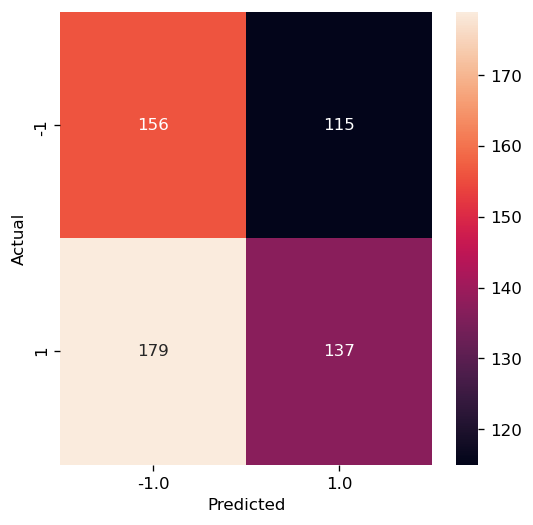

Accuracy:  0.4838160136286201


In [79]:
model_eval(SVR_results['Actual_Signal'],SVR_results['SVR_Pred_Signal']) 
print("Accuracy: ",accuracy_score(SVR_results['Actual_Signal'],SVR_results['SVR_Pred_Signal']))

# BenchMark

In [80]:
# All buy


# yesterday's Signal



# Trading Strategy 

In [81]:
data

,Date,EUA_Carbon,EUA_Ret,CO1_BrentCrude,Rotterdam_Coal,GSCI_NonEnergyIndex,TZT1_NatGas,STOXX600,EUA_Price_L1
0,2014-01-02,97.58,-0.024200,113.72,80.750000,31.36,54.582,325.82,97.58
1,2014-01-03,97.17,-0.004202,112.83,79.500000,31.23,54.493,327.64,97.17
2,2014-01-06,95.35,-0.018730,112.67,79.750000,31.25,54.652,326.98,95.35
3,2014-01-07,96.16,0.008495,113.29,79.600000,31.26,54.429,329.40,96.16
4,2014-01-08,93.94,-0.023087,113.09,81.900000,31.00,54.710,329.75,93.94
...,...,...,...,...,...,...,...,...,...
1963,2021-11-23,1295.52,-0.010396,81.18,146.888889,17.73,91.277,479.25,1295.52
1964,2021-11-24,1365.24,0.053816,81.12,149.444444,17.66,94.334,479.69,1365.24
1965,2021-11-26,1363.19,-0.022326,71.59,146.000000,16.51,88.122,464.05,1363.19
1966,2021-11-29,1389.66,0.019418,73.22,128.000000,16.47,93.445,467.24,1389.66


In [82]:
data['str_ret'] =data['Pred_Signal']*data['EUA_Ret']

data['strategy_cu_return']=0.
data['market_cu_return']=0.
data

KeyError: 'Pred_Signal'

In [ ]:
data['Pred_Signal'].unique()

In [ ]:
data.iloc[-testing_size:,data.columns.get_loc('strategy_cu_return')] = np.nancumsum(data['str_ret'][-testing_size:])

data.iloc[-testing_size:,data.columns.get_loc('market_cu_return')] = np.nancumsum(data['EUA_Ret'][-testing_size:])

data

In [ ]:
data[["EUA_Ret", "str_ret"]].sum()


In [ ]:
data['strategy_cu_return'][1584]

In [ ]:
Sharpe = (data['strategy_cu_return'][1584]-data['market_cu_return'][1584])\
           /np.nanstd(data['strategy_cu_return'][-testing_size:])

plt.plot(data['strategy_cu_return'][-testing_size:],color='g',label='Strategy Returns')
plt.plot(data['market_cu_return'][-testing_size:],color='r',label='Market Returns')
plt.figtext(0.14,0.9,s='Sharpe ratio: %.2f'%Sharpe)
plt.legend(loc='best')
plt.show()
